## Using PAMI version of Emotic dataset
### and opencv: https://realpython.com/face-recognition-with-python/

In [46]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import csv
%matplotlib inline

root_dir = '/Users/nealdesai/Documents/CSClasses/CS766-CV/project/'
cascPath = '/Users/nealdesai/Documents/CSClasses/CS766-CV/project/HumanEmotionRecognition/haarcascade_frontalface_default.xml'

In [2]:
!pwd

/Users/nealdesai/Documents/CSClasses/CS766-CV/project/HumanEmotionRecognition


In [3]:
annotations = loadmat('Annotations.mat')

In [4]:
annotations.keys()

dict_keys(['__header__', '__version__', '__globals__', 'test', 'train', 'val'])

In [5]:
print(annotations['train'].shape[1])
print(annotations['test'].shape)
print(annotations['val'].shape)

17077
(1, 4389)
(1, 2088)


In [6]:
for i,val in enumerate(annotations['train'][:,12][0]):
    print(i, ': ', val[0])

0 :  COCO_val2014_000000122997.jpg
1 :  mscoco/images
2 :  [(array([[640]], dtype=uint16), array([[425]], dtype=uint16))]
3 :  [(array(['mscoco'], dtype='<U6'), array([[(array([[122997]], dtype=int32), array([[558850]], dtype=int32))]],
      dtype=[('image_id', 'O'), ('annotations_id', 'O')]))]
4 :  [(array([[246,  63, 458, 380]], dtype=uint16), array([[(array([[array(['Engagement'], dtype='<U10')]], dtype=object),)]],
      dtype=[('categories', 'O')]), array([[(array([[5]], dtype=uint8), array([[3]], dtype=uint8), array([[8]], dtype=uint8))]],
      dtype=[('valence', 'O'), ('arousal', 'O'), ('dominance', 'O')]), array(['Female'], dtype='<U6'), array(['Adult'], dtype='<U5'))
 (array([[141,  47, 348, 343]], dtype=uint16), array([[(array([[array(['Disconnection'], dtype='<U13'),
        array(['Engagement'], dtype='<U10'),
        array(['Peace'], dtype='<U5')]], dtype=object),)]],
      dtype=[('categories', 'O')]), array([[(array([[6]], dtype=uint8), array([[4]], dtype=uint8), array

In [30]:

# Processes image metadata and passes to helper function to tag faces 
# def get_face_tags(img_data):
#     image_name = img_data[1][0]
#     image_path = root_dir + 'emotic/' + image_name + '/' + img_data[0][0]
#     person_struct = img_data[4][0]
#     face_coords = []
#     for p_num in range(person_struct.shape[0]):
#         person_info = person_struct[p_num]
#         body_coords = person_info[0][0]
#         face_coords.append(tag_face(img_data, image_path, body_coords, show=False, cropped=False))
#     return face_coords

def get_body_coords(img_data):
    if len(img_data) == 0:
        return []
    person_struct = img_data[4][0]
    body_coords = []
    for p_num in range(person_struct.shape[0]):
        person_info = person_struct[p_num]
        body = person_info[0][0]
        body_coords.append(body)
    return body_coords
        
def tag_face(img_data, img_path, body_dims=[0,0,0,0], show=False, cropped=True):
    body_coords = [int(x) for x in body_dims]
    col_img = cv2.imread(img_path)
    img = cv2.cvtColor(col_img, cv2.COLOR_BGR2GRAY)
    if show:
        print("original image: ")
        plt.imshow(img, cmap='gray')
        plt.show()
    if cropped:
        print("cropped image: ")
        img2 = img[body_coords[1]:body_coords[3], body_coords[0]:body_coords[2]]
        if show:
            plt.imshow(img2, cmap='gray')
            plt.show()
    faceCascade = cv2.CascadeClassifier(cascPath)
    if cropped:
        faces = faceCascade.detectMultiScale(img2, scaleFactor=1.1, minNeighbors=6, minSize=(30,30))
    else:
        faces = faceCascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=6, minSize=(30,30))
    # print(faces, type(faces))
    checked_faces = []
    for face in faces:
        if is_valid_face(face,img_data):
            checked_faces.append(face)
    if show:
        if cropped: 
            disp_img = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
            for (x, y, w, h) in checked_faces:
                cv2.rectangle(disp_img, (x, y), (x+w, y+h), (255, 120, 120), 5)
            plt.imshow(img2, cmap='gray')
            plt.show()
        else: 
            disp_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            for (x, y, w, h) in checked_faces:
                cv2.rectangle(disp_img, (x, y), (x+w, y+h), (255, 120, 120), 5)
            plt.imshow(disp_img)
            plt.show()
    return checked_faces

def is_valid_face(face, img_data):
    if img_data == []:
        return True 
    body_coords = get_body_coords(img_data)
    face_t = [face[0], face[1], face[0] + face[2], face[1] + face[3]]
    matched = False
    for body in body_coords:
        #print('face: ', face_t)
        #print('body: ', body)
        x_len = body[2] - body[0]
        y_len = body[3] - body[1]
        assert x_len >= 0
        assert y_len >= 0
        x_lower = body[0] - 0.05 * x_len
        x_upper = body[2] + 0.05 * x_len
        y_lower = body[1] - 0.05 * y_len 
        y_upper = y_lower + 0.5 * y_len
        #print('x_lower: ', x_lower)
        #print('x_upper: ', x_upper)
        #print('y_lower: ', y_lower)
        #print('y_upper: ', y_upper)
        if face_t[0] > x_lower and face_t[2] < x_upper and face_t[1] > y_lower and face_t[3] < y_upper:
            matched = True
        else: 
            matched = False
        #print('matched: ', matched)
    return matched 

# Takes the number of an image (starting indexed at 0), and retrieves relevant metadata 
def get_img_data(img_num):
    img_data = []
    for i,val in enumerate(annotations['train'][:,img_num][0]):
        img_data.append(val)
    image_name = img_data[1][0]
    image_path = root_dir + 'emotic/' + image_name + '/' + img_data[0][0]
    return (img_data, image_path)


def runTest(imageNum, display=False, save=True):
    faceCount = 0
    availableFaces = 0
    face_tags = {}
    if display:
        if imageNum > 50:
            print("Very large image number for displaying tags. Please reduce < 50.")
            return []
    for num in range(imageNum):
        if num % 50 == 0 and num != 0:
            print(num, ' of ', imageNum)
        data = get_img_data(num)
        b = tag_face(data[0], data[1], show=display, cropped=False)
        # print("face arr", b)
        if len(b) > 0:
            faceCount += len(b)
            if save:
                if data[1] not in face_tags:
                    face_tags[data[1]] = []
                for box in b:
                    x = box[0]
                    y = box[1]
                    w = box[2]
                    h = box[3]
                    face_tags[data[1]].append([x, y, x+w,  y+h])
        availableFaces += len(get_body_coords(data[0]))
    print("Total faces found: ", faceCount)   
    print("Total bodies in dataset: ", availableFaces)
    print("Hit rate: ", faceCount / availableFaces)
    return face_tags

original image: 


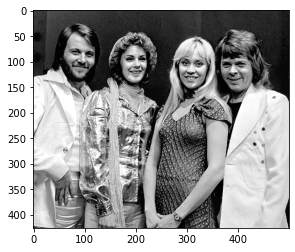

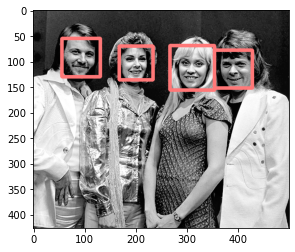

In [31]:
# Sample stock image from training article works fine 
a = tag_face([],'/Users/nealdesai/Documents/CSClasses/CS766-CV/project/HumanEmotionRecognition/abba.png', show=True, cropped=False)

In [32]:
# Find sample training images with multiple faces
for img in range(0,60):
    if len(annotations['train'][:,img][0][4][0]) > 1:
        print(img)


10
12
18
23
26
29
31
33
39
50
51
59


original image: 


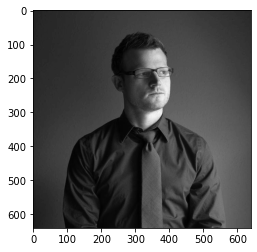

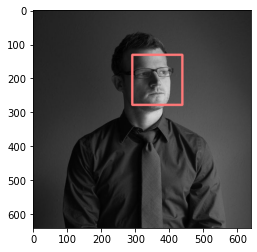

original image: 


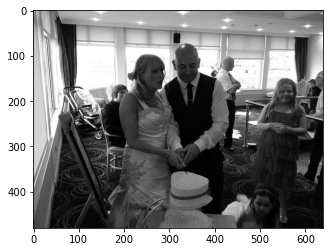

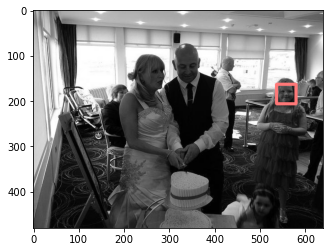

original image: 


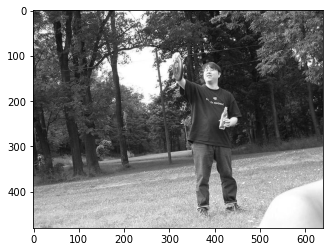

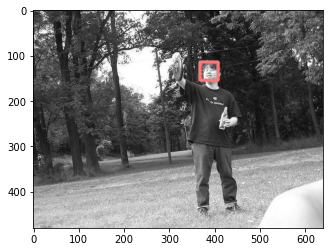

original image: 


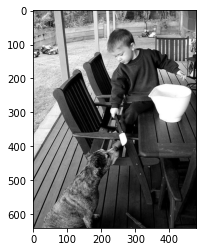

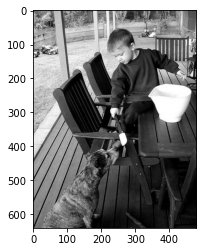

original image: 


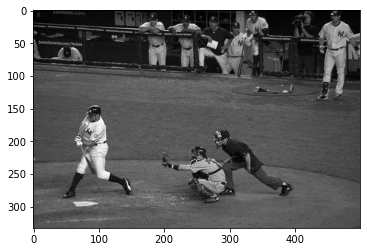

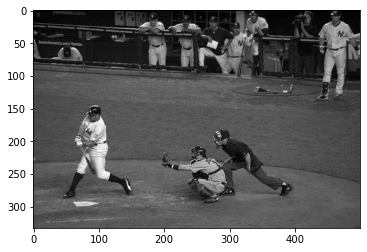

original image: 


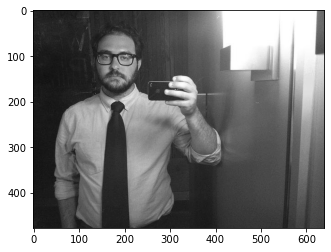

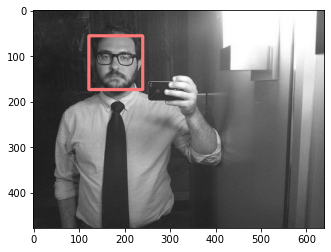

original image: 


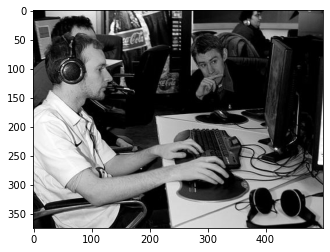

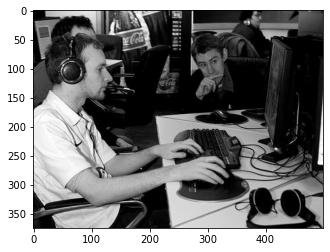

original image: 


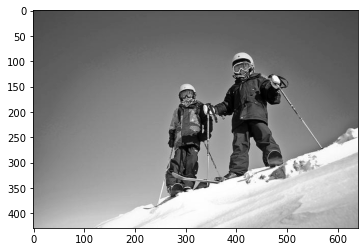

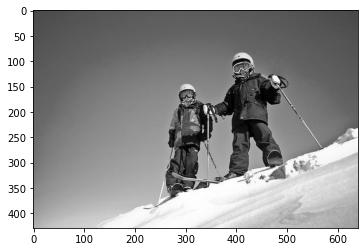

original image: 


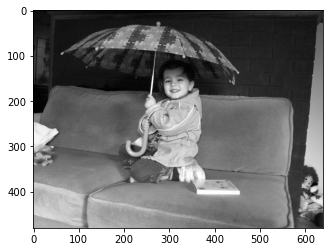

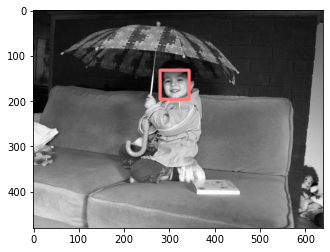

original image: 


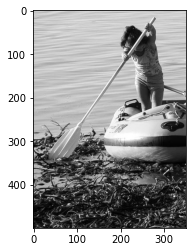

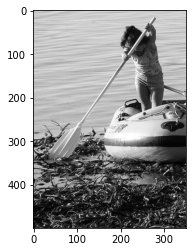

original image: 


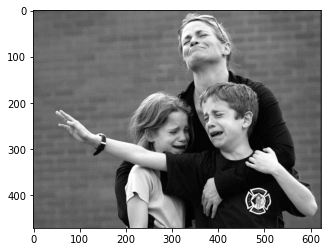

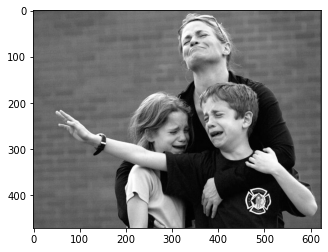

original image: 


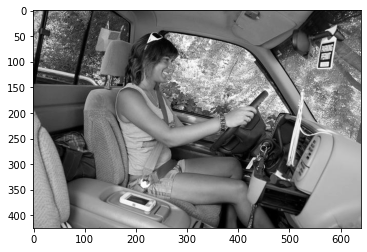

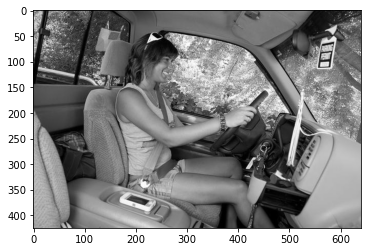

original image: 


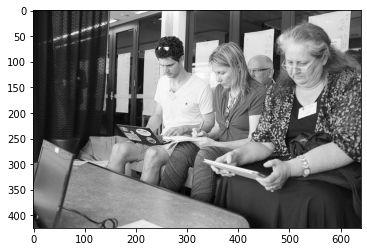

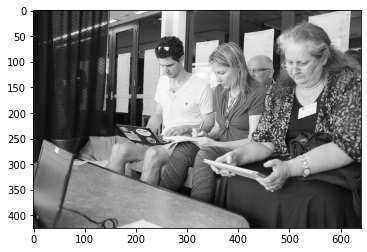

original image: 


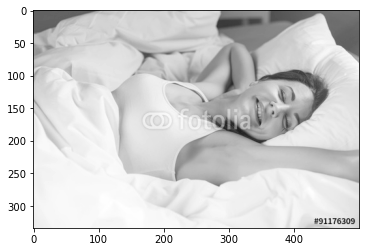

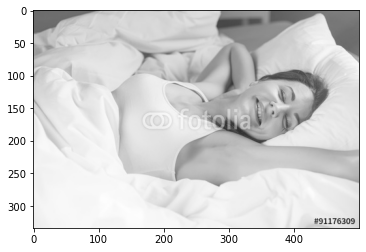

original image: 


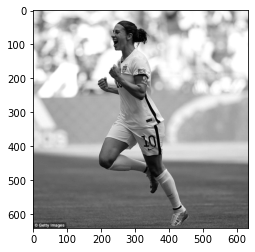

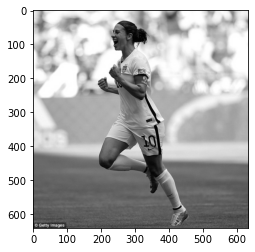

Total faces found:  5
Total bodies in dataset:  18
Hit rate:  0.2777777777777778


In [33]:
t = runTest(15, display=True)

In [34]:
t

{'/Users/nealdesai/Documents/CSClasses/CS766-CV/project/emotic/mscoco/images/COCO_val2014_000000562243.jpg': [[291,
   131,
   438,
   278]],
 '/Users/nealdesai/Documents/CSClasses/CS766-CV/project/emotic/mscoco/images/COCO_train2014_000000288841.jpg': [[537,
   163,
   580,
   206]],
 '/Users/nealdesai/Documents/CSClasses/CS766-CV/project/emotic/mscoco/images/COCO_val2014_000000558171.jpg': [[368,
   114,
   408,
   154]],
 '/Users/nealdesai/Documents/CSClasses/CS766-CV/project/emotic/mscoco/images/COCO_train2014_000000462955.jpg': [[122,
   56,
   240,
   174]],
 '/Users/nealdesai/Documents/CSClasses/CS766-CV/project/emotic/mscoco/images/COCO_train2014_000000006590.jpg': [[280,
   132,
   344,
   196]]}

In [35]:
tags = runTest(17077, display=False, save=True)

50  of  17077
100  of  17077
150  of  17077
200  of  17077
250  of  17077
300  of  17077
350  of  17077
400  of  17077
450  of  17077
500  of  17077
550  of  17077
600  of  17077
650  of  17077
700  of  17077
750  of  17077
800  of  17077
850  of  17077
900  of  17077
950  of  17077
1000  of  17077
1050  of  17077
1100  of  17077
1150  of  17077
1200  of  17077
1250  of  17077
1300  of  17077
1350  of  17077
1400  of  17077
1450  of  17077
1500  of  17077
1550  of  17077
1600  of  17077
1650  of  17077
1700  of  17077
1750  of  17077
1800  of  17077
1850  of  17077
1900  of  17077
1950  of  17077
2000  of  17077
2050  of  17077
2100  of  17077
2150  of  17077
2200  of  17077
2250  of  17077
2300  of  17077
2350  of  17077
2400  of  17077
2450  of  17077
2500  of  17077
2550  of  17077
2600  of  17077
2650  of  17077
2700  of  17077
2750  of  17077
2800  of  17077
2850  of  17077
2900  of  17077
2950  of  17077
3000  of  17077
3050  of  17077
3100  of  17077
3150  of  17077
3200  of  17

In [40]:
# Modifies path if image path changes 
def transform_path(project_dir, face_dict):
    transformed = {}
    for key in face_dict:
        s = key.split('emotic')
        new_path = project_dir + 'emotic' + s[1]
        transformed[new_path] = face_dict[key]
    return transformed

In [41]:
trans = transform_path('Users/monkey/', t)
trans

{'Users/monkey/emotic/mscoco/images/COCO_val2014_000000562243.jpg': [[291,
   131,
   438,
   278]],
 'Users/monkey/emotic/mscoco/images/COCO_train2014_000000288841.jpg': [[537,
   163,
   580,
   206]],
 'Users/monkey/emotic/mscoco/images/COCO_val2014_000000558171.jpg': [[368,
   114,
   408,
   154]],
 'Users/monkey/emotic/mscoco/images/COCO_train2014_000000462955.jpg': [[122,
   56,
   240,
   174]],
 'Users/monkey/emotic/mscoco/images/COCO_train2014_000000006590.jpg': [[280,
   132,
   344,
   196]]}

In [47]:
# open file for writing, "w" is writing
w = csv.writer(open("face_tags.csv", "w"))

# loop over dictionary keys and values
for key, val in tags.items():
    # write every key and value to file
    w.writerow([key, val])

In [49]:
!ls

Annotations.mat                     haarcascade_frontalface_default.xml
Colab_train_emotic.ipynb            inference.py
LICENSE                             loss.py
README Emotic Master.md             main.py
README.md                           mat2py.py
abba.png                            prepare_models.py
emotic.py                           test.py
emotic_dataset.py                   train.py
face_boxes.json                     yolo_inference.py
face_tags.csv                       yolo_utils.py
facial_tagging_exploration.ipynb
